<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/RAPID/notebooks/RAPID_calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting UniProt proteomes for Tempura species

## Setup

In [ ]:
!pip install BIO
!sudo apt install clustalw
# !pip install toytree toyplot
!git clone -b RAPID https://github.com/alibekk93/IDP_analysis
!cd /content/IDP_analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.4/279.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  clustalx seaview
The following NEW packages will be installed:
  clustalw
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 275 kB of archives.
After this operation, 818 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 clustalw amd64 2.1+lgpl-7 [275 kB]
Fetched 275 kB in 1s (268 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling t

In [ ]:
from IDP_analysis.packages_import import *
from IDP_analysis.idp_in_bacteria_functions import *

/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [ ]:
sns.set_theme(context='paper', style='white',  palette='colorblind')

Loading Tempura dataset

In [ ]:
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/200617_TEMPURA.csv', index_col=0)
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_bacteria_uniprot.csv', index_col=0)
tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_filtered.csv', index_col=0)

Only keeping bacteria with available assembly or accession numbers

In [ ]:
# tempura = tempura[tempura['superkingdom']=='Bacteria']
# tempura.dropna(subset='assembly_or_accession', inplace=True)
# tempura.reset_index(drop=True, inplace=True)

Classifying bacteria into groups:
1. Psychrophile: OGT <= 20
2. Mesophile: 20 < OGT <= 40
2. Thermophile: 40 < OGT

While this may be quite liberal, some "psychrohiles" with OGT = 20 have *antarctica* in their species name, so it should be fair enough

In [ ]:
tempura['group'] = pd.cut(tempura['Topt_ave'], bins=[-float('inf'), 20, 40, float('inf')],
                          labels=['psychrophilic', 'mesophilic', 'thermophilic'])

Loading all_proteins

In [ ]:
# all_proteins = pd.read_csv('/content/all_proteins.csv', index_col=0)
# all_proteins_filtered = pd.read_csv('/content/all_proteins_filtered.csv', index_col=0)
all_proteins_rapid = pd.read_csv('/content/all_proteins_rapid.csv', index_col=0)
all_proteins_disordered = pd.read_csv('/content/all_proteins_disordered.csv', index_col=0)

Merging all_proteins with temura

In [ ]:
all_protein_tempura = all_proteins_rapid.merge(tempura, left_on='Species', right_on='genus_and_species')
all_protein_tempura_idp = all_proteins_disordered.merge(tempura, left_on='Species', right_on='genus_and_species')

Loading cluster dataframes

In [ ]:
interesting_clusters = pd.read_csv('/content/IDP_analysis/datafiles/clusters/interesting_clusters.csv', index_col=0)
disordered_clusters = pd.read_csv('/content/IDP_analysis/datafiles/clusters/disordered_clusters.csv', index_col=0)

Loading RAPID_disorder values

In [ ]:
# rapid_disorder_values = pd.read_csv('/content/IDP_analysis/datafiles/RAPID/RAPID_disorder_values.csv', index_col=0)

## Combining partial RAPID results and loading into all_proteins

In [ ]:
rapid_disorder_values = pd.DataFrame(columns = ['Prot. ID', 'Disorder Content %'])

In [ ]:
# set number of csv files with partial RAPID calculation results
n = 17
# iterate through each file and concatenate to all_proteins_filtered
for i in tqdm(range(n)):
  # make filename with addition of '0' if 1-9
  if i+1 < 10:
    filename = f'0{i+1}.csv'
  else:
    filename = f'{i+1}.csv'
  # read csv with RAPID result
  rapid_result = pd.read_csv(filename)
  rapid_result = rapid_result[['Prot. ID', 'Disorder Content %']]
  # append RAPID disorder prediciton to overall dataframe
  rapid_disorder_values = pd.concat([rapid_disorder_values, rapid_result], axis=0)

In [ ]:
# rapid_disorder_values.to_csv('RAPID_disorder_values.csv')

Appending RAPID disorder values to all_proteins_filtered

In [ ]:
# all_proteins_rapid = all_proteins_filtered.join(rapid_disorder_values.set_index('Prot. ID'),
#                                                    on='ID', how='inner')

In [ ]:
all_proteins_rapid['RAPID_disorder'] = all_proteins_rapid['Disorder Content %'] / 100
all_proteins_rapid.drop('Disorder Content %', axis=1, inplace=True)

# all_proteins_rapid['RAPID_fully_disordered'] = all_proteins_rapid['RAPID_disorder'] >= 0.5
# all_proteins_rapid['RAPID_n_disordered_residues'] = all_proteins_rapid['RAPID_disorder'] * all_proteins_rapid['Length']

In [ ]:
# all_proteins_rapid.to_csv('all_proteins_rapid.csv')

## FCR / NCPR filtering

In [ ]:
def compute_fcr(row):
    aa_seq = row['Sequence']
    n = len(aa_seq)
    f_plus = sum(aa_seq.count(char) for char in ['R', 'K', 'H']) / n # Histidine?
    f_minus = sum(aa_seq.count(char) for char in ['D', 'E']) / n
    ncpr = abs(f_plus - f_minus)
    fcr = (f_plus + f_minus)
    return pd.Series([f_plus, f_minus, ncpr, fcr])

In [ ]:
all_proteins_rapid[['f_plus', 'f_minus', 'ncpr', 'fcr']] = all_proteins_rapid.apply(compute_fcr, axis=1)

In [ ]:
all_proteins_rapid['idp_type'] = None

In [ ]:
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] < 0.25) & (all_proteins_rapid['ncpr'] < 0.25), 'idp_type'] = 1
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] >= 0.25) & (all_proteins_rapid['fcr'] <= 0.35) &\
                      (all_proteins_rapid['ncpr'] <= 0.35), 'idp_type'] = 2
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] > 0.35) & (all_proteins_rapid['ncpr'] <= 0.35), 'idp_type'] = 3
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] > 0.35) & (all_proteins_rapid['ncpr'] > 0.35) &\
                      (all_proteins_rapid['f_minus'] > 0.35), 'idp_type'] = 4
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] > 0.35) & (all_proteins_rapid['ncpr'] > 0.35) &\
                      (all_proteins_rapid['f_plus'] > 0.35), 'idp_type'] = 5

Filter out "disordered" proteins - these are either:
1. IDP type 3, 4 or 5
2. RAPID_disorder >= 0.5
3. Have at least 100 disordered residues as predicted by RAPID

The last point is to include longer proteins that just have a section of IDR. RAPID does not provide disorder at residue level, so it's as good as we can get to having a filter for 30 consecutive disordered residues

In [ ]:
disordered_filter = (all_proteins_rapid['idp_type'] > 2) | \
                    (all_proteins_rapid['RAPID_disorder'] >= 0.5) | \
                    (all_proteins_rapid['RAPID_disorder'] * all_proteins_rapid['Length'] >= 100)
all_proteins_rapid['disordered'] = disordered_filter
all_proteins_disordered = all_proteins_rapid[disordered_filter]

In [ ]:
# all_proteins_disordered.to_csv('all_proteins_disordered.csv')

In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))

# sns.scatterplot(data=all_proteins_rapid, x='f_plus', y='f_minus',
#                 hue='idp_type')

# ax.set_xlim(0, 0.75)
# ax.set_ylim(0, 0.75)

# fig.show()

In [ ]:
# fig.savefig('IDP_types.svg')

In [ ]:
# all_proteins_disordered.groupby('idp_type').mean()

In [ ]:
type_counts = all_protein_tempura_idp.groupby(['group', 'idp_type'], as_index=False).size()
type_counts.set_index('group', inplace=True)

In [ ]:
group_counts = type_counts.groupby(['group']).sum()['size']

In [ ]:
type_counts['fraction'] = type_counts['size'] / group_counts

In [ ]:
# type_counts.reset_index(inplace=True)

In [ ]:
psychrophilic_fractions = type_counts.loc['psychrophilic', 'fraction'].values
mesophilic_fractions = type_counts.loc['mesophilic', 'fraction'].values
thermophilic_fractions = type_counts.loc['thermophilic', 'fraction'].values

In [ ]:
type_fractions_df = pd.DataFrame(data={'IDP type':[1,2,3,4,5],
                                       'Psychrophilic':psychrophilic_fractions,
                                       'Mesophilic':mesophilic_fractions,
                                       'Thermophilic':thermophilic_fractions},
                                 index=[1, 2, 3, 4, 5])

In [ ]:
type_fractions_df

,IDP type,Psychrophilic,Mesophilic,Thermophilic
1,1,0.216322,0.217593,0.104233
2,2,0.468282,0.427200,0.254762
3,3,0.310050,0.349601,0.634524
4,4,0.001069,0.000766,0.000529
5,5,0.004277,0.004839,0.005952


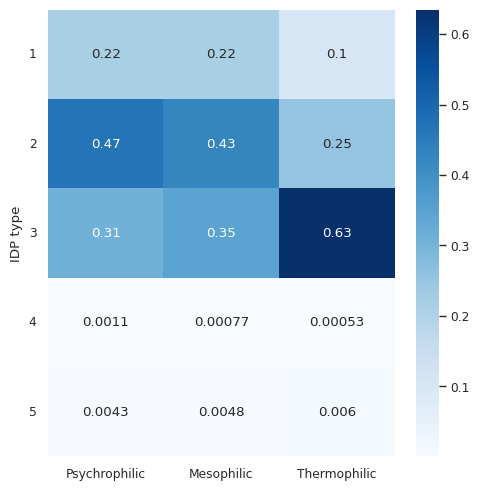

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(type_fractions_df.iloc[:, 1:], cmap='Blues', annot=True)
ax.set_ylabel('IDP type')
plt.yticks(rotation=0)

plt.tight_layout()

fig.show()

## EDA for Overall IDP abundance ~ optimal temerature relationship

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 8))

# sns.kdeplot(data=all_proteins_rapid[all_proteins_rapid['RAPID_fully_disordered']],
#                 x='Length', y='RAPID_disorder', alpha=0.5, fill=True, ax=ax)
# ax.set_xlim(0, 500)
# fig.show()

In [ ]:
species_rapid_disorder = all_proteins_rapid.groupby('Species').mean()[['RAPID_disorder']]
tempura = tempura.join(species_rapid_disorder, how='inner', on='genus_and_species')

species_rapid_idp_count = all_proteins_disordered.groupby('Species').count()[['RAPID_disorder']]
species_rapid_idp_count.columns = ['IDP_count']
tempura = tempura.join(species_rapid_idp_count, how='inner', on='genus_and_species')

species_rapid_protein_count = all_proteins_rapid.groupby('Species').count()[['RAPID_disorder']]
species_rapid_protein_count.columns = ['protein_count']
tempura = tempura.join(species_rapid_protein_count, how='inner', on='genus_and_species')
tempura['IDP_percentage'] = tempura['IDP_count'] / tempura['protein_count']

<ipython-input-40-1d0640aecf3f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  species_rapid_disorder = all_proteins_rapid.groupby('Species').mean()[['RAPID_disorder']]


In [ ]:
FOD_OGT_line_model = sm.OLS(tempura['RAPID_disorder'], sm.add_constant(tempura['Topt_ave'])).fit()
FOD_OGT_poly_model = sm.OLS(tempura['RAPID_disorder'], sm.add_constant(tempura['Topt_ave']**2)).fit()
print(FOD_OGT_line_model.summary())
print(FOD_OGT_poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:         RAPID_disorder   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.198
Date:                Sun, 03 Dec 2023   Prob (F-statistic):             0.0747
Time:                        19:04:35   Log-Likelihood:                 688.74
No. Observations:                 313   AIC:                            -1373.
Df Residuals:                     311   BIC:                            -1366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1403      0.005     29.034      0.0

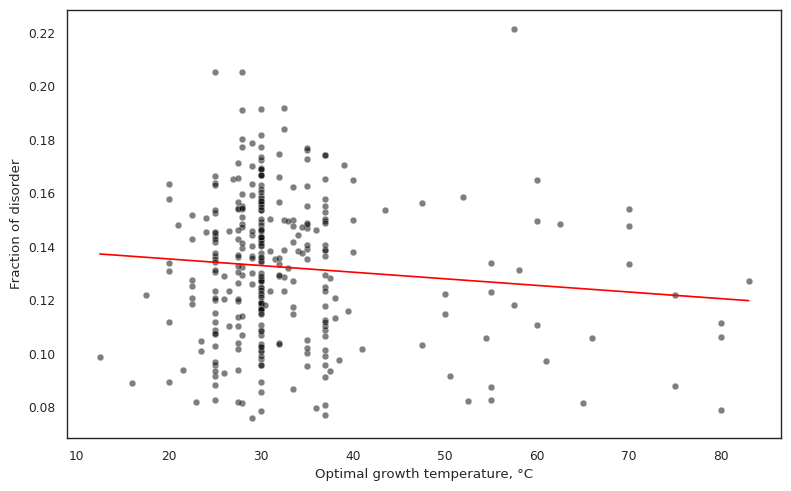

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=tempura, x='Topt_ave', y='RAPID_disorder', color='black', ax=ax, alpha=0.5)
plt.ylabel('Fraction of disorder')
plt.xlabel('Optimal growth temperature, °C')

sns.lineplot(x=tempura['Topt_ave'], y=FOD_OGT_line_model.predict(sm.add_constant(tempura['Topt_ave'])), ax=ax, color='red')
# sns.lineplot(x=tempura['Topt_ave'], y=FOD_OGT_poly_model.predict(sm.add_constant(tempura['Topt_ave']**2)), ax=ax, color='green')

plt.tight_layout()

fig.show()
# fig.savefig('FOD_OGT.svg')

In [ ]:
scipy.stats.shapiro(FOD_OGT_line_model.resid)

ShapiroResult(statistic=0.9906068444252014, pvalue=0.04269010201096535)

In [ ]:
scipy.stats.shapiro(FOD_OGT_poly_model.resid)

ShapiroResult(statistic=0.9906030297279358, pvalue=0.04260316118597984)

<Axes: >

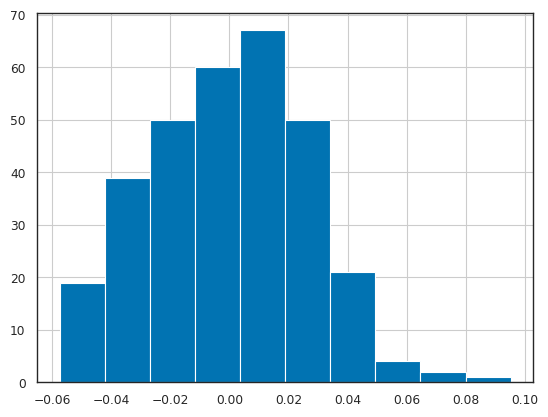

In [ ]:
FOD_OGT_line_model.resid.hist()

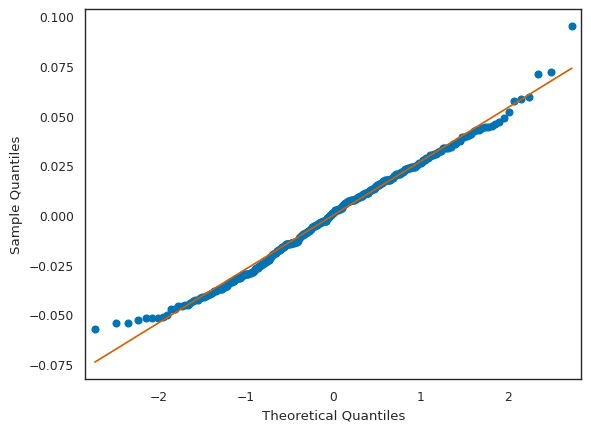

In [ ]:
sm.qqplot(FOD_OGT_line_model.resid, line='r')
plt.show()

In [ ]:
cIDP_OGT_line_model = sm.OLS(tempura['IDP_count'], sm.add_constant(tempura['Topt_ave'])).fit()
cIDP_OGT_poly_model = sm.OLS(tempura['IDP_count'], sm.add_constant(tempura['Topt_ave']**2)).fit()
print(cIDP_OGT_line_model.summary())
print(cIDP_OGT_poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:              IDP_count   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.276
Date:                Sun, 03 Dec 2023   Prob (F-statistic):             0.0223
Time:                        19:18:56   Log-Likelihood:                -2135.4
No. Observations:                 313   AIC:                             4275.
Df Residuals:                     311   BIC:                             4282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        399.7692     40.076      9.975      0.0

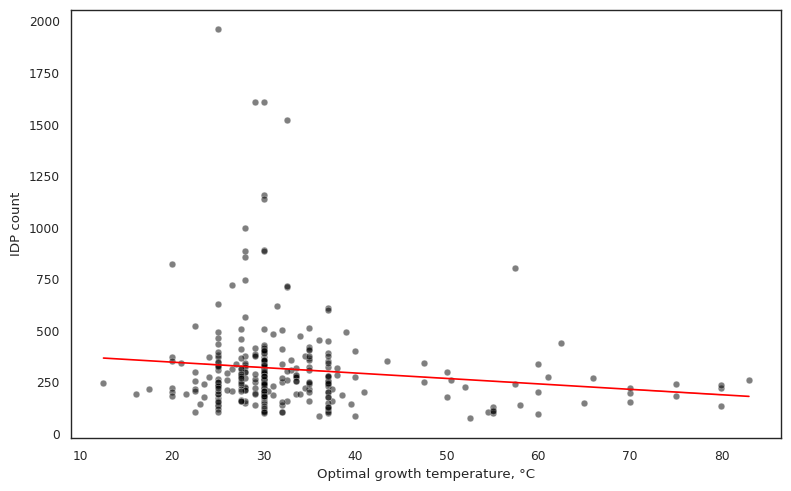

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=tempura, x='Topt_ave', y='IDP_count', color='black', ax=ax, alpha=0.5)
plt.ylabel('IDP count')
plt.xlabel('Optimal growth temperature, °C')

sns.lineplot(x=tempura['Topt_ave'], y=cIDP_OGT_line_model.predict(sm.add_constant(tempura['Topt_ave'])), ax=ax, color='red')
# sns.lineplot(x=tempura['Topt_ave'], y=cIDP_OGT_poly_model.predict(sm.add_constant(tempura['Topt_ave']**2)), ax=ax, color='green')

plt.tight_layout()

fig.show()
# fig.savefig('IDPcount_OGT.svg')

In [ ]:
pIDP_OGT_line_model = sm.OLS(tempura['IDP_percentage'], sm.add_constant(tempura['Topt_ave'])).fit()
pIDP_OGT_poly_model = sm.OLS(tempura['IDP_percentage'], sm.add_constant(tempura['Topt_ave']**2)).fit()
print(pIDP_OGT_line_model.summary())
print(pIDP_OGT_poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:         IDP_percentage   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     27.16
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           3.42e-07
Time:                        19:13:57   Log-Likelihood:                 691.28
No. Observations:                 313   AIC:                            -1379.
Df Residuals:                     311   BIC:                            -1371.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0585      0.005     12.196      0.0

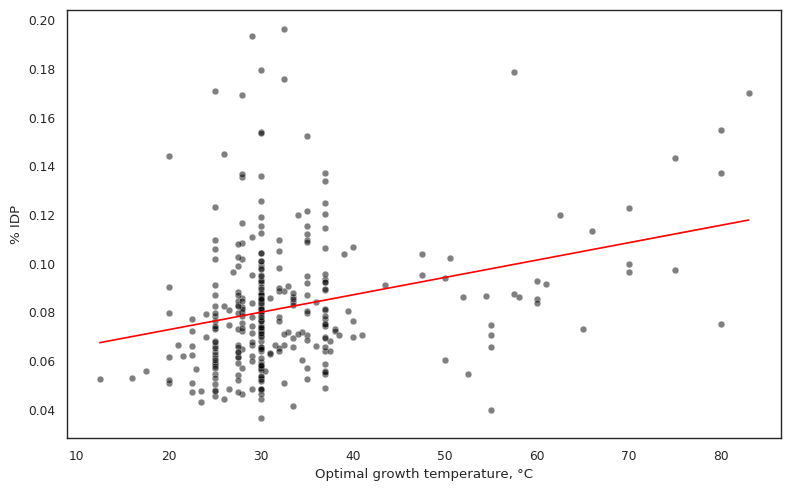

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=tempura, x='Topt_ave', y='IDP_percentage', color='black', ax=ax, alpha=0.5)
plt.ylabel('% IDP')
plt.xlabel('Optimal growth temperature, °C')

sns.lineplot(x=tempura['Topt_ave'], y=pIDP_OGT_line_model.predict(sm.add_constant(tempura['Topt_ave'])), ax=ax, color='red')
# sns.lineplot(x=tempura['Topt_ave'], y=pIDP_OGT_poly_model.predict(sm.add_constant(tempura['Topt_ave']**2)), ax=ax, color='green')

plt.tight_layout()

fig.show()
# fig.savefig('IDPpercentage_OGT.svg')

In [ ]:
size_OGT_line_model = sm.OLS(tempura['protein_count'], sm.add_constant(tempura['Topt_ave'])).fit()
size_OGT_poly_model = sm.OLS(tempura['protein_count'], sm.add_constant(tempura['Topt_ave']**2)).fit()
print(size_OGT_line_model.summary())
print(size_OGT_poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:          protein_count   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     44.03
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           1.44e-10
Time:                        19:41:46   Log-Likelihood:                -2728.2
No. Observations:                 313   AIC:                             5460.
Df Residuals:                     311   BIC:                             5468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5415.8732    266.340     20.334      0.0

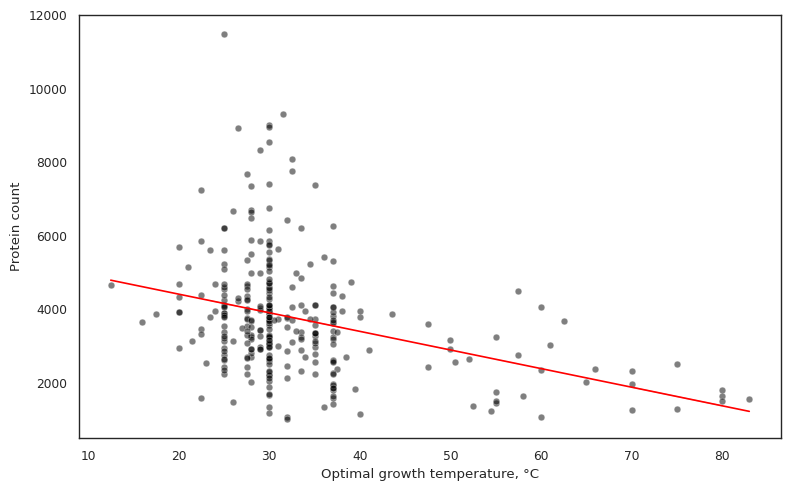

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=tempura, x='Topt_ave', y='protein_count', color='black', ax=ax, alpha=0.5)
plt.ylabel('Protein count')
plt.xlabel('Optimal growth temperature, °C')

sns.lineplot(x=tempura['Topt_ave'], y=size_OGT_line_model.predict(sm.add_constant(tempura['Topt_ave'])), ax=ax, color='red')
# sns.lineplot(x=tempura['Topt_ave'], y=size_OGT_poly_model.predict(sm.add_constant(tempura['Topt_ave']**2)), ax=ax, color='green')

plt.tight_layout()

fig.show()
# fig.savefig('size_OGT.svg')

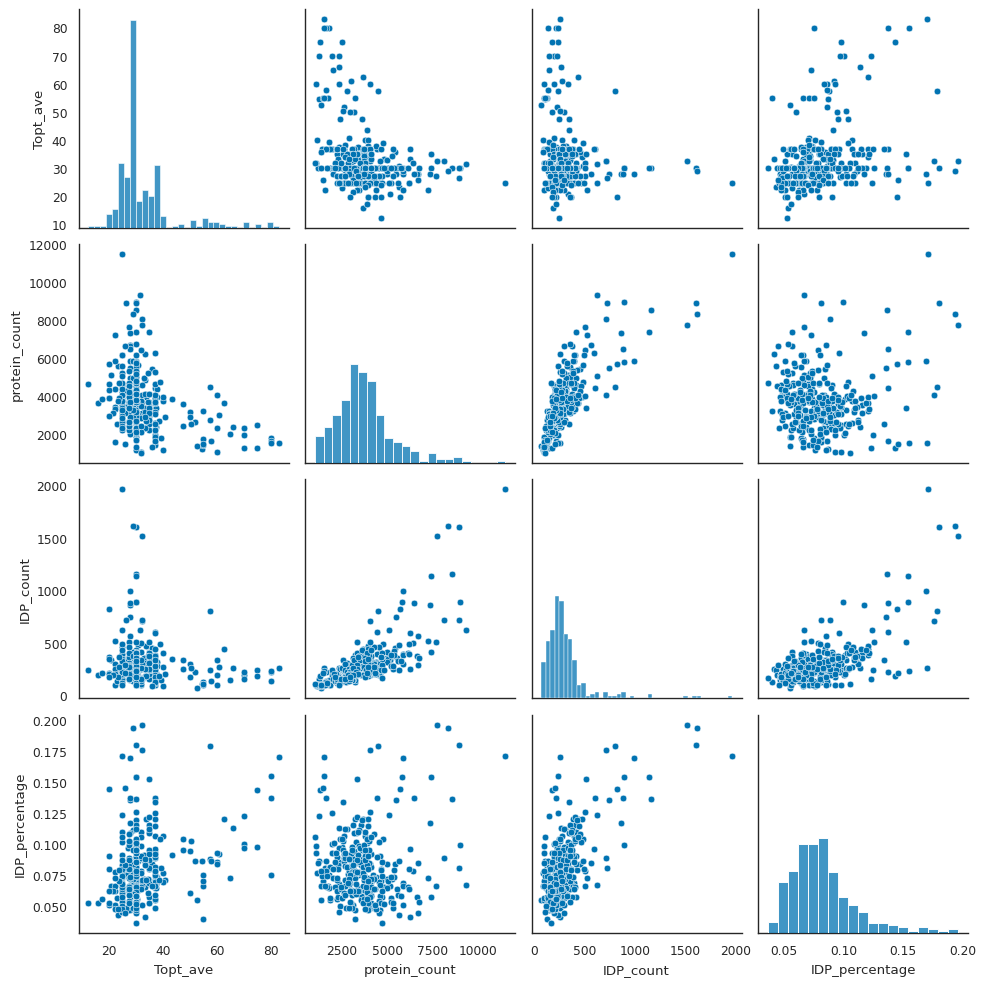

In [ ]:
sns.pairplot(tempura[['Topt_ave', 'protein_count', 'IDP_count', 'IDP_percentage']])

## Clustering all proteins using CD-HIT

In [ ]:
# # saving all proteins to a single fasta file
# with open('/content/all_proteins.fasta', 'w') as fasta_file:
#   for _, row in all_proteins_rapid.iterrows():
#     id = row['ID']
#     seq = row['Sequence']
#     fasta_file.write(f'>{id}\n{seq}\n')

CH-HIT ran on local system using command:
```
cd-hit -i all_proteins.fasta -o all_proteins_70 -c 0.7
```

Importing CD-HIT results

In [ ]:
clustered_proteins_file = '/content/IDP_analysis/datafiles/CD-HIT/all_proteins_70.clstr'

all_proteins_rapid['cluster'] = '0'
clusters = {}

# Read the clustered proteins file and store clusters
with open(clustered_proteins_file ,'r') as f:
  for line in f:
    if line.startswith('>Cluster'):
      cluster_id = int(line.strip().split()[1])
      clusters[cluster_id] = []
    else:
      protein_id = line.strip().split('>')[1].split('...')[0]
      clusters[cluster_id].append(protein_id)

In [ ]:
protein_cluster_mapping = {cid: proteins for cid, proteins in clusters.items()}
# Reverse cluster dictionary to have ID:cluster
protein_cluster_mapping = {protein_id: cluster for cluster, proteins in protein_cluster_mapping.items() for protein_id in proteins}
# Map clusters to df
all_proteins_rapid['cluster'] = all_proteins_rapid['ID'].map(protein_cluster_mapping)

We will filter to find clusters that:

1. Have at least 10 proteins
2. Have at least 1 disordered protein
2. Have at least 1 non-disordered protein

We will call these clusters `interesting_clusters` because they are, well, interesting

We will store clusters with only disordered proteins as `disordered_clusters`

In [ ]:
cluster_groups = all_proteins_rapid.groupby('cluster').agg({'disordered':['max', 'min'], 'ID':'count'})

In [ ]:
min_cluster_size = 10

only_disordered = cluster_groups[(cluster_groups['disordered']['min']) & (cluster_groups['ID']['count']>=min_cluster_size)].index
mixed_clusters = cluster_groups[(cluster_groups['disordered']['max']) & (~cluster_groups['disordered']['min']) & \
                                (cluster_groups['ID']['count']>=min_cluster_size)].index

In [ ]:
len(only_disordered)

95

In [ ]:
interesting_clusters = all_proteins_rapid[all_proteins_rapid['cluster'].isin(mixed_clusters)]
# interesting_clusters.to_csv('interesting_clusters.csv')

In [ ]:
disordered_clusters = all_proteins_rapid[all_proteins_rapid['cluster'].isin(only_disordered)]
# disordered_clusters.to_csv('disordered_clusters.csv')

Saving all proteins from `interesting_clusters` as `fasta` to predict their disorder using **fIDPnn**


In [ ]:
interesting_clusters = interesting_clusters[interesting_clusters['Length'] >= 20]
disordered_clusters = disordered_clusters[disordered_clusters['Length'] >= 20]

In [ ]:
# !mkdir /content/IDP_analysis/clustered_fastas/

mkdir: cannot create directory ‘/content/IDP_analysis/clustered_fastas/’: File exists


In [ ]:
# # define the maximum sequences per file
# max_sequences_per_file = 430

# # split the DataFrame into chunks of max_sequences_per_file and save as FASTA files
# for i, chunk in enumerate(range(0, len(disordered_clusters), max_sequences_per_file)):
#   chunk_df = disordered_clusters.iloc[chunk:chunk + max_sequences_per_file]
#   # create a FASTA file for the chunk
#   fasta_file_path = f'/content/IDP_analysis/clustered_fastas/clustered_proteins_{i+1}.fasta'
#   with open(fasta_file_path, 'w') as fasta_file:
#     for _, row in chunk_df.iterrows():
#       id = row['ID']
#       seq = row['Sequence']
#       fasta_file.write(f'>{id}\n{seq}\n')

In [ ]:
# !zip -r /content/clustered_fastas.zip /content/IDP_analysis/clustered_fastas -i '*.fasta'
# from google.colab import files
# files.download('/content/clustered_fastas.zip')

  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_4.fasta (deflated 59%)
  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_3.fasta (deflated 62%)
  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_2.fasta (deflated 59%)
  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_1.fasta (deflated 61%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cluster analysis

In [ ]:
fIDPnn_dfs = {}
df_lines = []

with open('/content/fIDPnn_ALL.csv', 'rb') as f:
  for i, line in enumerate(tqdm(f.readlines())):
    line_decoded = line.decode('utf-8')
    if line_decoded[0] == '>':
      if df_lines != []:
        current_df = pd.DataFrame(np.array(df_lines)[1:, :], columns=np.array(df_lines)[0])
        fIDPnn_dfs[protein_id] = current_df.apply(pd.to_numeric, errors='ignore')
      protein_id = line_decoded[1:-1]
      df_lines = []
    else:
      df_lines.append(line_decoded.strip().split(','))

100%|██████████| 4142502/4142502 [01:14<00:00, 55306.73it/s]


In [ ]:
# RAPID_calcs = {}
# fIDPnn_calcs = {}

# for protein_id in tqdm(fIDPnn_dfs.keys()):
#   try:
#     RAPID_calcs[protein_id] = all_proteins_rapid[all_proteins_rapid['ID']==protein_id]['RAPID_disorder'].iloc[0]
#     fIDPnn_calcs[protein_id] = fIDPnn_dfs[protein_id]['Predicted Score for Disorder'].mean()
#   except:
#     print(protein_id)
#     continue

  0%|          | 28/11311 [00:03<33:30,  5.61it/s]

A0A0M9ACC1[WARNING]


100%|██████████| 11311/11311 [20:19<00:00,  9.28it/s]


In [ ]:
# X = np.array(list(RAPID_calcs.values()))
# y = np.array(list(fIDPnn_calcs.values()))

# model_comparison_ols = sm.OLS(y, X).fit()

In [ ]:
# print(model_comparison_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.854
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                          6.636e+04
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        20:28:32   Log-Likelihood:                          11295.
No. Observations:               11310   AIC:                                 -2.259e+04
Df Residuals:                   11309   BIC:                                 -2.258e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

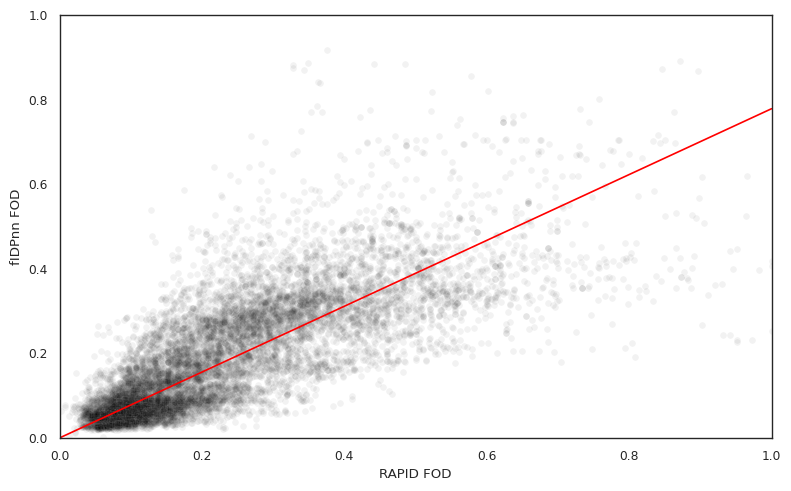

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5))

# sns.scatterplot(x=RAPID_calcs.values(), y=fIDPnn_calcs.values(), alpha=0.05, color='black')
# ax.plot(model_comparison_ols.predict([0, 1]), color='red')

# plt.ylabel('fIDPnn FOD')
# plt.xlabel('RAPID FOD')
# plt.ylim(0, 1)
# plt.xlim(0, 1)

# plt.tight_layout()
# fig.show()
# # fig.savefig('RAPID_vs_fIDPnn.svg')

RAPID seems to be an adequate model when compared with fIDPnn, even though it generally does **underpredict** disorder based on coefficient

In [273]:
fIDPnn_disorder_list = []

for id in tqdm(interesting_clusters['ID']):
  try:
    fIDPnn_disorder_list.append(fIDPnn_dfs[id]['Predicted Score for Disorder'])
  except:
    fIDPnn_disorder_list.append(None)

interesting_clusters['fIDPnn_disorder'] = fIDPnn_disorder_list

100%|██████████| 11312/11312 [00:00<00:00, 112273.17it/s]


In [ ]:
aligned_clusters = {}

for cluster in tqdm(interesting_clusters['cluster']):
  cluster_df = interesting_clusters[interesting_clusters['cluster']==cluster].copy()

  cluster_df['disorder_aligned'] = align_disorder(disorder_values=cluster_df['fIDPnn_disorder'],
                                                  seqs=cluster_df['Sequence'], ids=cluster_df['ID'])[1]

  cluster_df['group'] = [tempura[tempura['genus_and_species']==s]['group'].iloc[0] for s in cluster_df['Species']]

  cluster_df['color'] = cluster_df['group'].map({'psychrophilic':'blue',
                                                   'mesophilic':'green',
                                                   'thermophilic':'red'})
  cluster_df['species_tag'] = cluster_df['Species']

  aligned_clusters[cluster] = cluster_df

  # plot_aligned_cluster(df=cluster_df, cluster=cluster, mav=10)

  0%|          | 7/11312 [01:10<17:38:15,  5.62s/it]

In [ ]:
def plot_cluster(cluster_df):

  # fIDP_disorder_dict = {}

  for id in cluster_df['ID']:
    try:
      df = fIDPnn_dfs[id]
      df['Predicted Score for Disorder'].plot()
    except:
      continue

In [ ]:
interesting_clusters['cluster'].unique()[:10]

array([239905, 739489, 864394, 896643, 865740, 845716, 730795, 891615,
       713553, 773025])

In [279]:
test_cluster_n = 208799

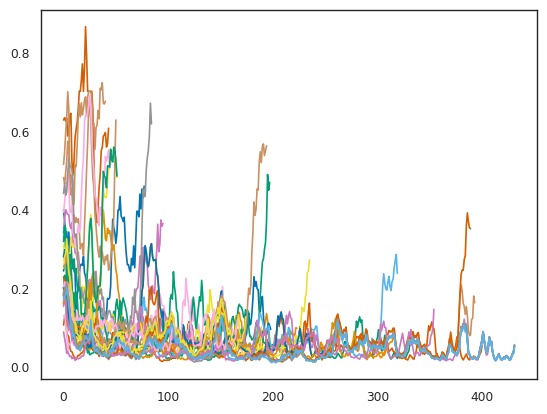

In [250]:
plot_cluster(interesting_clusters[interesting_clusters['cluster']==test_cluster_n])

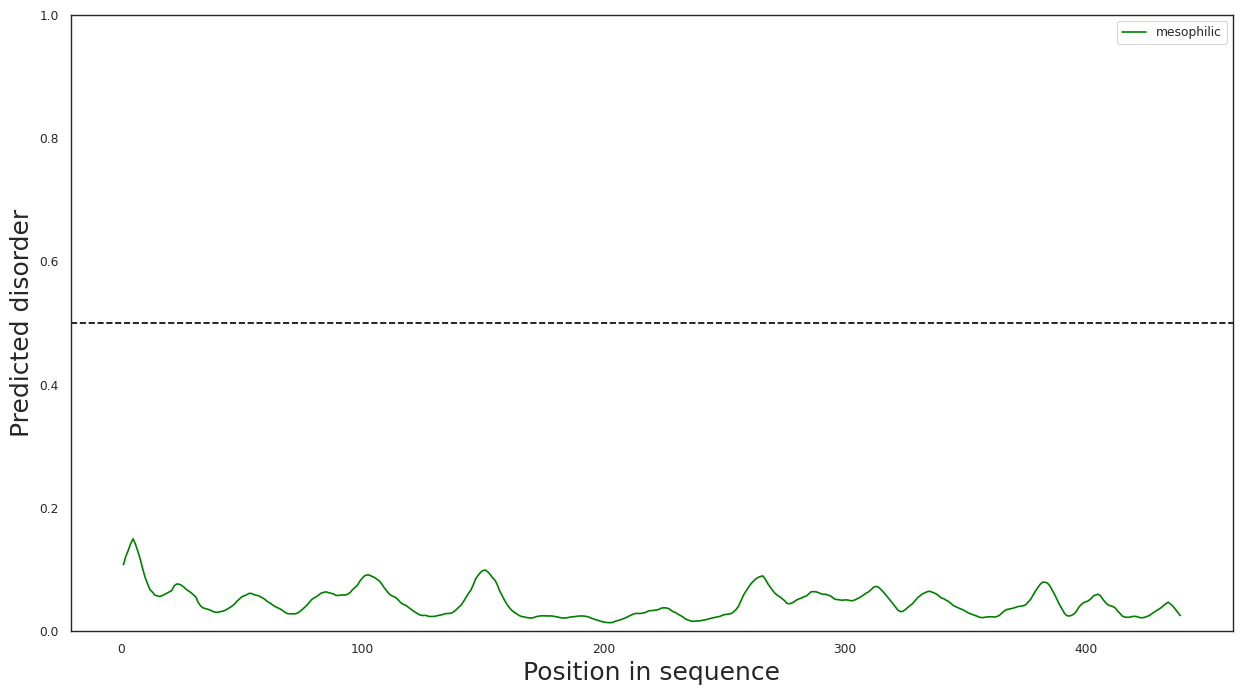

In [280]:
test_cluster = interesting_clusters[interesting_clusters['cluster']==test_cluster_n].copy()

test_cluster['disorder_aligned'] = align_disorder(disorder_values=test_cluster['fIDPnn_disorder'],
                                                  seqs=test_cluster['Sequence'], ids=test_cluster['ID'])[1]

test_cluster['group'] = [tempura[tempura['genus_and_species']==s]['group'].iloc[0] for s in test_cluster['Species']]

test_cluster['color'] = test_cluster['group'].map({'psychrophilic':'blue',
                                                   'mesophilic':'green',
                                                   'thermophilic':'red'})
test_cluster['species_tag'] = test_cluster['Species']

plot_aligned_cluster(df=test_cluster, cluster=test_cluster_n, mav=10)

In [264]:
interesting_cluster_sizes = {}
failures = []

for cluster in tqdm(interesting_clusters['cluster'].unique()):
  try:
    cluster_df = interesting_clusters[interesting_clusters['cluster']==cluster].copy()
    cluster_df['disorder_aligned'] = align_disorder(disorder_values=[fIDPnn_dfs[id]['Predicted Score for Disorder'] for id in cluster_df['ID']],
                                                    seqs=cluster_df['Sequence'], ids=cluster_df['ID'])[1]

    cluster_df['group'] = [tempura[tempura['genus_and_species']==s]['group'].iloc[0] for s in cluster_df['Species']]
    interesting_cluster_sizes[cluster] = (cluster_df.groupby('group').size(), cluster_df.groupby(['group'])['Species'].unique().count())
  except:
    failures.append(cluster)
    continue

100%|██████████| 607/607 [11:10<00:00,  1.10s/it]


In [ ]:
interesting_cluster_coverage ={}

for cluster in tqdm(interesting_cluster_sizes.keys()):
  interesting_cluster_coverage[cluster] = (interesting_cluster_sizes[cluster]/tempura.groupby('group').size()).fillna(0)

100%|██████████| 605/605 [00:02<00:00, 236.63it/s]


In [ ]:
sum(interesting_cluster_coverage.values())/len(interesting_cluster_coverage.values())

group
mesophilic       0.062438
psychrophilic    0.078972
thermophilic     0.029952
dtype: float64

In [253]:
interesting_cluster_sizes_df = pd.DataFrame(interesting_cluster_sizes).T.fillna(0)

In [254]:
interesting_cluster_sizes_df

group,mesophilic,psychrophilic,thermophilic
239905,184.0,3.0,28.0
739489,146.0,4.0,17.0
864394,12.0,0.0,1.0
896643,17.0,1.0,4.0
865740,47.0,2.0,3.0
...,...,...,...
154146,15.0,0.0,0.0
182779,0.0,10.0,0.0
133217,11.0,0.0,0.0
570941,23.0,0.0,0.0
